In [1]:
# tensor flow 5일차@

In [32]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()
# encoding을 하기위해서
# S,E,P... 순으로
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz단어나무놀이소녀연습사랑'] 
# 0:S , 1:E, 2:P 순으로 번호매겨줌 enumerate
num_dic = {n: i for i, n in enumerate(char_arr)}
dic_len = len(num_dic) # 
print(dic_len)
#seq2seq번역망
seq_data = [['word', '단어'], ['wood', '나무'],
           ['game', ' 놀이'], ['girl', '소녀'],
           ['test','연습'], ['love','사랑']]

def make_batch(seq_data):
    input_batch = []
    output_batch = []
    target_batch = []
    for seq in seq_data: # ['word', '단어'] #
        input = [num_dic[n] for n in seq[0]] # word -> 번호순으로 25, 17 ..등등 char_arr에 들어있는 순번대로
        # 첫번째 입력되는 데이터는 'word'이 학습된 smoking gun
        output = [num_dic[n] for n in ('S'+seq[1])] # 훈련된 특징값이 나옴
        target = [num_dic[n] for n in (seq[1]+'E')] # 끝을 확인하기 위해서
        # identity matrix 단위행렬 -> 원핫 인코딩 용도로 사용
        input_batch.append(np.eye(dic_len)[input]) # 4X41차원으로 생성 2차원배열로
        output_batch.append(np.eye(dic_len)[output])
        target_batch.append(target)
    return input_batch, output_batch, target_batch

learning_rate = 0.01
n_hidden = 128
total_epoch = 100
n_class = n_input = dic_len
# encoder, decoder 용 데이터 주입변수
enc_input = tf.placeholder(tf.float32, [None, None, n_input])
dec_input = tf.placeholder(tf.float32, [None, None, n_input])
targets = tf.placeholder(tf.int64, [None,None])

41


In [33]:
with tf.variable_scope('encode'):
    # FFNN 한개 입력 -> 가중치 -> 출력 (n_hidden)
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden) # 입력  41 x 128 이 가중치
    # 과적합을 방지하기 위해 계산회로 생략 - random 하게 생략
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5, seed=100)
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype=tf.float32)
with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell,output_keep_prob=0.5)
    # 2 x 42
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input, initial_state=enc_states, dtype=tf.float32)
    # initial_state은 앞의 인코더 망에서 출력된 states값 : 마지막 cell의 출력값
    # 앞의 데이터를 다 고려한 특징
    # 두개의 망을 연결!

In [34]:
# 6 x 2 x 128 로 나오고있음
#  41개
model = tf.layers.dense(outputs, n_class, activation=None)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [38]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz단어나무놀이소녀연습사랑'] 
# 범주형 데이터로 만들어줌
num_dic = {n: i for i, n in enumerate(char_arr)}
dic_len= len(num_dic)
print(dic_len) # 41개
# seq2seq 번역망
seq_data = [['word', '단어'], ['wood', '나무'], ['game', '놀이'], ['girl', '소녀'],
           ['test', '연습'], ['love', '사랑']]
def make_batch(seq_data):
    input_batch = []
    output_batch = []
    target_batch = []
    for seq in seq_data:
        input = [num_dic[n] for n in seq[0]] # 첫번째 입력되는 데이터는 'word'이 학습된 smoking gun
        output = [num_dic[n] for n in ('S' + seq[1])]
        target = [num_dic[n] for n in (seq[1] + 'E')] # 끝을 확인하기 위해서
        input_batch.append(np.eye(dic_len)[input]) #4X41
        output_batch.append(np.eye(dic_len)[output]) # 2X41
        target_batch.append(target)
    return input_batch, output_batch, target_batch

learning_rate = 0.01
n_hidden = 128
total_epoch = 100
n_class = n_input = dic_len

# encoder, decoder용 데이터 주입 변수
enc_input = tf.placeholder(tf.float32, [None, None, n_input])
dec_input = tf.placeholder(tf.float32, [None, None, n_input])
targets = tf.placeholder(tf.int64, [None, None])

with tf.variable_scope('encode'):
    # FFNN  한개 입력 -> 가중치 -> 출력 (n_hidden)
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden) # 41X128
    # 과적합 방지하기 위해 계산회로 생략 - random하게 생략
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5, seed=100) # 셀 4개, 셀당 41개 데이터
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype=tf.float32)
    
with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input, initial_state=enc_states, dtype=tf.float32) # 2X41
    # initial_state = enc_states 두 개의 망을 연결
    # 앞의 인코더망에서 출력된 states값 : 마지막 cell의 출력
    # 앞의 데이터를 다 고려한 특징
# outputs 6 X 3 X 128
# nclass 41
model = tf.layers.dense(outputs, n_class, activation=None) # 
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

41


In [39]:
input_batch, output_batch, target_batch = make_batch(seq_data)
for epoch in range(total_epoch):
    _, loss = sess.run([optimizer, cost],
                      feed_dict={enc_input:input_batch,
                                dec_input:output_batch,
                                targets:target_batch})
    print('Epoch:', '%04d'%(epoch+1),'cost = ', '{:.6f}'.format(loss))

Epoch: 0001 cost =  3.716554
Epoch: 0002 cost =  2.643712
Epoch: 0003 cost =  1.637584
Epoch: 0004 cost =  0.969343
Epoch: 0005 cost =  0.812048
Epoch: 0006 cost =  0.409807
Epoch: 0007 cost =  0.325812
Epoch: 0008 cost =  0.327433
Epoch: 0009 cost =  0.309425
Epoch: 0010 cost =  0.235525
Epoch: 0011 cost =  0.207553
Epoch: 0012 cost =  0.185693
Epoch: 0013 cost =  0.210563
Epoch: 0014 cost =  0.118978
Epoch: 0015 cost =  0.150119
Epoch: 0016 cost =  0.130938
Epoch: 0017 cost =  0.113834
Epoch: 0018 cost =  0.202711
Epoch: 0019 cost =  0.122610
Epoch: 0020 cost =  0.114828
Epoch: 0021 cost =  0.024567
Epoch: 0022 cost =  0.039424
Epoch: 0023 cost =  0.077874
Epoch: 0024 cost =  0.019230
Epoch: 0025 cost =  0.005337
Epoch: 0026 cost =  0.021675
Epoch: 0027 cost =  0.012866
Epoch: 0028 cost =  0.012532
Epoch: 0029 cost =  0.009704
Epoch: 0030 cost =  0.006471
Epoch: 0031 cost =  0.013644
Epoch: 0032 cost =  0.009083
Epoch: 0033 cost =  0.009828
Epoch: 0034 cost =  0.004926
Epoch: 0035 co

In [40]:
def translate(word):
    # 모델의 자리수는 일치해야하기때문에
    seq_data = [word, 'P' * len(word)] # PPPP
    # 1 x 4 x 41
    # 1 x 4 x 41
    input_batch, output_batch, target_batch = make_batch([seq_data])
    prediction = tf.argmax(model,2) # 면, 행, 열중에 2번째인 열을 중심해라
    # 6x3x41 중 41의 max값
    result = sess.run(prediction, feed_dict={enc_input:input_batch,
                                            dec_input:output_batch,
                                            targets:target_batch})
    decoded = [char_arr[i] for i in result[0]] # 5 x 41
    end = decoded.index('E')
    translated = ''.join(decoded[:end])
    
    return translated
print('word -> ', translate('word'))

word ->  단어


In [41]:
def translate(word):
    seq_data = [word, "P" * len(word)]
    
    input_batch, output_batch, target_batch = make_batch([seq_data])
    prediction = tf.argmax(model, 2)
    
    result = sess.run(prediction, feed_dict={enc_input: input_batch,
                                             dec_input: output_batch,
                                             targets: target_batch})
    decoded = [char_arr[i] for i in result[0]]
    
    try:
        end = decoded.index("E")
        translated = "".join(decoded[:end])
        return translated
        
    except Exception as ex:
        pass
print('word -> ', translate('word'))

word ->  단어


In [ ]:
# 카카오 API 

In [113]:
import json
import cv2 # computer cvison
import requests
import sys
LIMIT_PX = 1024
LIMIT_BYTE = 1024*1024
LIMIT_BOX = 40
# pip install opencv-python

# OCR.절차
# 이미지 사이즈 조정
# 글씨를 둘러싼 Box 를 detection

In [114]:
def kakao_ocr_resize(image_path:str):
    image = cv2.imread('2.jpg')
    height, width, _ = image.shape
    if LIMIT_PX < height or LIMIT_PX < width:
        ratio = float(LIMIT_PX) / max(height, width)
        image = cv2.resize(image, None, fx=ratio, fy=ratio)
        height, width, _ = height, width, _ = image.shape
        image_path = "{}_resized.jpg".format('2')
        cv2.imwrite(image_path, image)
        return image_path
    return None

In [115]:
# 사용법
# openapi 란 함수를 원격호출 (remote call)
def kakao_ocr_detect(image_path: str, appkey: str):
    API_URL = 'http://kapi.kakao.com/v1/vision/text/detect'
    headers = {'Authorization':'KakaoAK {}'.format('0fb10dd3ce3fca2a83151ab0ca2ec021')}
    image = cv2.imread('2.jpg')
    # naver -> jpg형식만 
    jpeg_image = cv2.imencode(".jpg", image)[1]
    data = jpeg_image.tobytes()
    # 네트워크일 때 -> 데이터가 시리얼로 가야함 (네트워크 모뎀)
    # 8개 line으로 구성 -> 현재는 4개의 회선만 사용->1개는전송,1개는수신
    # 네트워크를 통해 함수 호출 (시간) : 비동기방식
    # 네트워크를 통해서 원격호출
    # 동기 방식, 비동기방식(다른작업중 - event)
    # 대표적인 비동기 통신방식으로 AJAX
    # flask에서 사용
    # 인터넷에서 표준 데이터 포멧 : json
    return requests.post(API_URL, headers=headers, files={"file":data})

In [116]:
def kakao_ocr_recognize(image_path: str, boxes: list, appkey: str):
    API_URL = 'https://kapi.kakao.com/v1/vision/text/recognize'
    headers = {'Authorization': 'KakaoAK {}'.format('0fb10dd3ce3fca2a83151ab0ca2ec021')}
    image = cv2.imread('2.jpg')
    jpeg_image = cv2.imencode('.jpg', image)[1]
    data = jpeg_image.tobytes()
    # OCR, 인식은 BOX로 택스트 구역을 확인하고
    # recognize 인식한다.
    return requests.post(API_URL, headers=headers,
                        files={"file": data}, data={"boxes": json.dumps(boxes)})

In [118]:
def main():
    image_path, appkey = sys.argv[1], sys.argv[2]
    resize_impath = kakao_ocr_resize(image_path)
    output = kakao_ocr_detect(image_path, appkey).json()
    boxes = output['result']['boxes']
    boxes = boxes[:min(len(boxes), LIMIT_BOX)]
    output = kakao_ocr_recognize(image_path,boxes, appkey).json()
    return output
output = main()
output['result']

TypeError: 'int' object is not subscriptable

In [110]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('2.jpg',0)
print(img.shape)


(400, 295)


In [111]:
# pip install opencv-python
import json
import cv2 # computer vision tool (이미지, 동영상 처리)
import requests # html 페이지 요청
import sys
LIMIT_PX = 1024
LIMIT_BYTE = 1028*1024
LIMIT_BOX = 40
# OCR 절차
# 이미지 사이즈 조정
# 글씨를 둘러싼 Box를 detection

def kakao_ocr_resize(image_path: str):
    image = cv2.imread('2.jpg')
    height, width, _ = image.shape
    if LIMIT_PX < height or LIMIT_PX < width:
        ratio = float(LIMIT_PX) / max(heigth, width)
        image = cv2.resize(image, None, fx=ratio, fy=ratio)
        height, width, _ = height, width, _ = image.shape
        image_path = "{}_resize.jpg".format('2')
        cv2.imwrite(image_path, image)
        return image_path
    return None

# 사용법
# open api 함수를 원격호출 (remote call)
def kakao_ocr_detect(image_path: str, appkey: str):
    API_URL ='https://kapi.kakao.com/v1/vision/text/detect'
    headers = {'Authorization': 'KakaoAK {}'.format('0fb10dd3ce3fca2a83151ab0ca2ec021')}
    image = cv2.imread('2.jpg') # 이미지 로드
    # naver는 jpg만, gif 애니메이션 지원, png 투명도 지원
    jpeg_image = cv2.imencode('.jpg', image)[1]
    data = jpeg_image.tobytes() # 네크워크 전송 -> serialization
    # 네트워크일 때 => 데이터가 시리얼로 가야 함 (모뎀)
    # 8개 라인으로 구성, 4개 회선만 사용 (1개 전송, 1개 수신)
    # 네트워크를 통해 함수 호출 (시간) : 비동기 방식
    # 동기 방식(호출 후 돌아올 때까지 기다림), 비동기 방식(다른 작업 중 -event 받아서 작업)
    # 대표적인 비동기 통신 방식이 AJAX : 웹 브라우저 내부적 처리
    # 인터넷 표준 데이터 형식 json
    return requests.post(API_URL, headers=headers, files={"file": data})

def kakao_ocr_recognize(image_path: str, boxes: list, appkey: str):
    API_URL = 'https://kapi.kakao.com/v1/vision/text/recognize'
    headers = {'Authorization': 'KakaoAK {}'.format('0fb10dd3ce3fca2a83151ab0ca2ec021')}
    image = cv2.imread('2.jpg')
    jpeg_image = cv2.imencode('.jpg', image)[1]
    data = jpeg_image.tobytes()
    # 인식은 BOX로 텍스트 구역을 확인하고, recognize 인식한다.
    return requests.post(API_URL, headers=headers, files={"file": data}, data={"boxes": json.dumps(boxes)})

def main():
    image_path, appkey = sys.argv[1], sys.argv[2]
    resize_impath = kakao_ocr_resize(image_path)
    output = kakao_ocr_detect(image_path, appkey).json()
    boxes = output['result']['boxes']
    boxes = boxes[:min(len(boxes), LIMIT_BOX)]
    output = kakao_ocr_recognize(image_path, boxes, appkey).json()
    return output
output = main()
output['result']

{'recognition_words': ['임수증 (고객용)',
  '매장명 : 마한네일산',
  '사업자번호: 123-45-67891',
  '대표자명 : 전지현',
  '전화번호: O2-1544-4639',
  '주소ø경기 안양시 동안구 시민대로 401,1106호',
  '판매일시: 2017-11-24오후 2.38.m',
  '1.찔제거(실장님',
  '10.mmT',
  '2. 레케어(실장님)',
  '10.m',
  '3, 젤갈라(실장님)',
  '50.00m',
  '[할인] 20%',
  '- 10,000',
  '합계',
  '7o.00m',
  '향미',
  '-10.00m',
  '선출사용',
  '-60.0m',
  '소계',
  '!',
  '부가세',
  '[',
  '힙합계',
  'ø',
  '[박현선]님의',
  '정보',
  '잡여포인트',
  '선물잔액',
  '90.0m',
  '선물만료의',
  '2018-11-24']}

In [141]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [142]:
import cv2
import numpy as np
history = 30
# cap = cv2.VideoCapture(0) 이거로하면 카메라 영상으로 받아들임
cap = cv2.VideoCapture('corrupted_video.mp4')
if (cap.isOpened()==False): # 파일이 없거나 장치가 없거나
    print("ERROR")
fgbg = cv2.createBackgroundSubtractorMOG2() # 백그라운드 필터
while(cap.isOpened()):
    ret, frame = cap.read() # 1개의 frame -> 동영상은 ntsc방식 초당29
    if ret == True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgmask = fgbg.apply(gray,learningRate=1.0/history)
        cv2.imshow("Frame",fgmask
                  ) # 이미지 출력
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

In [129]:
# 동영상 저장
import numpy as np
# 동영상 데이터 전처리 -> AI model 훈련 -> 실시간인식
import cv2
cap = cv2.VideoCapture("corrupted_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID') # codec
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640,480))
while(cap.isOpened()):
    ret, frame = cap.read() # embeded 장칭 ai npu 삼성엑시노스
    if ret == True:
        frame = cv2.flip(frame,0) # 여기다가 카메라로 인식하게해서 보여주면 차선변경 코드로 전환이 가능함
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out.write(frame)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
out.release()
cv2.destroyAllWindows()

In [185]:
# AE (auto encoder)
# 오토인코더는 비지도학습 : 데이터의 특징 추출 : PCA 데이터 재해석(직교하는 축으로)
# autoencoder input: 자기자신 == output도 자기자신

In [ ]:
# denoising autoencoder
- 원본, noise가 있는 학습 데이터
- 학습은 noise가 있는 학습 데이터 -> 가중치
- autoencoder 는 denosing을 한다.

In [170]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [178]:
%matplotlib inline
from tensorflow.examples.tutorials.mnist import  input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows, n_image_cols, top=1.,
                          bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g, count in zip(gs, range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name+'_vis.png')
    plt.show()
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500

In [179]:
corruption_level = 0.3
X = tf.placeholder('float', [None, n_visible], name='X')
mask = tf.placeholder('float', [None, n_visible], name='mask')

W_init_max = 4 * np.sqrt(6./ (n_visible+n_hidden))
# 균등 분포에서 데이터생성
W_init = tf.random_uniform(shape=[n_visible, n_hidden],
                          minval = -W_init_max, maxval=W_init_max)
W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]), name='b')

In [180]:
W_prime = tf.transpose(W)
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')
def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    return Z
Z = model(X, mask, W, b, W_prime, b_prime)
# 가중치에 이미지의 특성이 추출

In [181]:
# X 원본데이터 == Z 예측데이터
# autoencoder input : 자기자신 == output도 자기자신
# autoencoder는 noise를 추가함 : 원본의 특징을 추출한다
cost = tf.reduce_sum(tf.pow(X - Z,2))
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)
predict_op = Z
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels,mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [160]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#denoising autoencoder
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows, n_image_cols, top=1.,
                          botton=1., right=1., left=0., hspace=0., wspace=0.)
    for g, count in zip(gs, range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name+'_vis.png')
    plt.show()
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500

corruption_level = 0.3
X = tf.placeholder('float', [None, n_visible], name='X')
mask = tf.placeholder('float', [None, n_visible], name='mask')
W_init_max = 4 * np.sqrt(6./ (n_visible+n_hidden))
W_init = tf.random_uniform(shape=[n_visible, n_hidden],
                          minval = -W_init_max, maxval=W_init_max)
W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]), name='b')

W_prime = tf.transpose(W)
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')
def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    return Z
Z = model(X, mask, W, b, W_prime, b_prime)

cost = tf.reduce_sum(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)
predict_op = Z

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


0 114777.58
1 98478.5
2 89702.77
3 84727.82
4 78772.03
5 75303.484
6 75133.97
7 73700.555
8 72138.805
9 71014.195
10 69141.7
11 68192.77
12 67660.914
13 65828.79
14 66605.05
15 66457.77
16 65891.016
17 64894.16
18 64860.73
19 64754.086
20 64245.004
21 63875.8
22 62692.305
23 62155.85
24 62843.137
25 63756.023
26 61827.758
27 63225.082
28 63318.15
29 63536.836
30 61973.78
31 62362.035
32 61357.773
33 61412.234
34 61231.273
35 61886.11
36 60765.83
37 61130.984
38 61833.887
39 60058.047
40 60671.934
41 60791.758
42 60489.23
43 60220.41
44 60157.03
45 60208.547
46 59892.996
47 59585.99
48 59556.938
49 59962.926
50 59184.234
51 60256.5
52 59318.82
53 59480.945
54 58637.35
55 59031.242
56 59630.25
57 59691.7
58 59776.79
59 59727.83
60 58904.824
61 58862.074
62 59468.895
63 58256.15
64 57795.0
65 58025.805
66 58775.29
67 57715.035
68 58038.78
69 57903.223
70 57701.06
71 58057.7
72 58360.703
73 57310.54
74 57564.555
75 59121.742
76 57425.113
77 57209.67
78 58352.312
79 56933.09
80 57769.57
81 

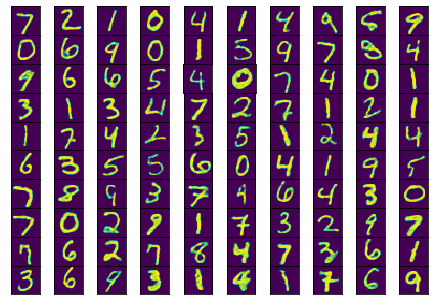

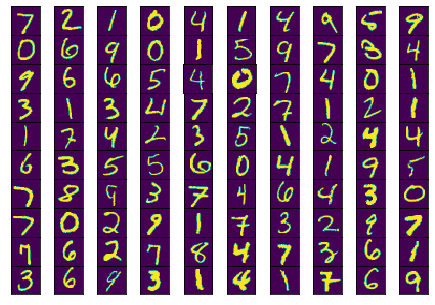

In [184]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(100):
        for start, end in zip(range(0, len(trX), 128),
                             range(128, len(trX)+1,128)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1,1-corruption_level,input_.shape)
            sess.run(train_op, feed_dict={X:input_, mask:mask_np})
        # 이항분포로 마스크 생성 + 노이즈(원본이미지 노이즈)
        mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
        print(i, sess.run(cost, feed_dict={X:teX, mask:mask_np}))
    mask_np = np.random.binomial(1,1 - corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: teX[:100], mask: mask_np})
    input_imgs = teX[:100]
vis(predicted_imgs,'pred') # 예측된 이미지.
vis(input_imgs, 'in') # 입력이미지

In [ ]:
# 판별모델 (discrimitive model) / 
# Variational autoencoder (VAE)
# 변동인코더
# generative model 생성 모델 -> 확률 평균 + 분산 (분포)
# 잠재변수 (latent variables) : 키, 남자 

In [201]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
train, test = tf.keras.datasets.mnist.load_data()
train_x, train_y = train
from functools import partial
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs # 입력이 출력으로 
learning_rate = 0.001
# without scaling 초기화
initializer = tf.contrib.layers.variance_scaling_initializer()

11493376/11490434 [==============================] - 1s 0us/step


In [202]:
# 매개변수 일부를 고정할때
# dense 라는 함수에서 activation을 상수취급하겠다는말임
my_dense_layer = partial(tf.layers.dense, activation = tf.nn.elu, kernel_initializer=initializer) # (-1 을고려한 relu)
X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)

hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
# 평균, 분산 * 노이즈
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype = tf.float32)

hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
# 자기 자신값 28 * 28 = 784
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

In [203]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
# 재구축손실
reconstruction_loss = tf.reduce_sum(xentropy)
# epsilon 상수 : 부동소수점을 비교 0.0001 차가 : 0.0001 이하면 같은것으로 판단
eps = 1e-10 # epsilon 상수 : 로그의 성질 : 0이면 무한대
# cost function : 
# log liklihood 우도 확률
# 지연손실 ( 확률분포 곡선 )
latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 1 - tf.log(eps + tf.square(hidden3_sigma)))
loss = reconstruction_loss + latent_loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init =tf.global_variables_initializer()

In [204]:
import sys
n_digits =60
n_epochs = 3
batch_size = 150
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches),end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\t Reconstruction loss:", reconstruction_loss_val,"\t Latent loss:", latent_loss_val)
        codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
        outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})


09% Train total loss: 36312.26 	 Reconstruction loss: 26550.635 	 Latent loss: 9761.627
1 Train total loss: 34106.69 	 Reconstruction loss: 23782.684 	 Latent loss: 10324.008
2 Train total loss: 27420.164 	 Reconstruction loss: 22993.996 	 Latent loss: 4426.167


In [ ]:
# 가중치를 통과한 데이터 ( test ) : 모델오나성
# PCA처럼 비지도 학습의 특성으로 추출된 데이터(분류와 예측)                                                                                                    